(Note that all units unless otherwise mentioned are SI units.)

In [1]:
%%capture
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
import pickle,os
from multislice import prop,prop_utils
from os.path import dirname as up
from tqdm import tqdm_notebook
import h5py

Importing all the required libraries.

In [9]:
pwd = os.getcwd()
os.chdir(up(up(os.getcwd()))+str('/zp_database/hard_xray_zp'))
parameters = pickle.load(open('parameters.pickle','rb'))
for i in parameters : print(i,' : ',parameters[i])
wavel = parameters['wavelength in m']
step_xy = parameters['step_xy']
zp_coords = parameters['zp_coords']
grid_size = parameters['grid_size']
beta  = parameters['beta']
delta = parameters['delta']
step_xy = parameters['step_xy']
wavel = parameters['wavelength in m']
f = parameters['focal_length']
L = step_xy*grid_size
os.chdir(pwd)

grid_size  :  55296
step_xy  :  4.738222262408356e-09
energy(in eV)  :  10000
wavelength in m  :  1.23984e-10
focal_length  :  0.01
zp_coords  :  [-0.000131, 0.000131, -0.000131, 0.000131]
delta  :  2.9912e-05
beta  :  2.2073e-06


In [3]:
f_ = h5py.File("zp_rotate.hdf5")
zp_rotate = f_['zp_rotate']
number_of_steps = zp_rotate.attrs['rotation_slices']
step_z = zp_rotate.attrs['step_z']
f_.close()

In [4]:
def get_pattern(i):
    temp  = np.zeros((55296,55296))
    temp_ = np.zeros((15000,15000))
    f_ = h5py.File("zp_rotate.hdf5")
    zp_rotate = f_['zp_rotate']
    zp_rotate.read_direct(temp_, np.s_[:,:,i], np.s_[:,:])
    f_.close()
    N = int(55296/2)
    n = 7500
    temp[N-n:N+n,N-n:N+n] = temp_
    del temp_
    return temp

In [5]:
wavefront = np.ones((55296,55296),dtype='complex64')

In [6]:
ne.set_vml_num_threads(24)

p = prop_utils.decide(step_z,step_xy,L,wavel)

for i in tqdm_notebook(range(number_of_steps)):
    pattern = get_pattern(i)
    wavefront = prop_utils.modify_two_materials_case_2(wavefront,step_z,wavel,
                                            pattern,delta,beta,
                                            np.ones(np.shape(pattern))-pattern,0,0)
    wavefront,L1 = p(wavefront,step_xy,L,wavel,step_z)

wave_exit = wavefront
del wavefront

propogator to be used : Transfer Function


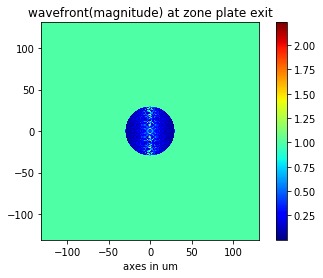

In [7]:
plt.imshow(np.abs(wave_exit),extent=np.array([-L1/2,L1/2,-L1/2,L1/2])*1e6,cmap='jet')
plt.xlabel('axes in um')
plt.title('wavefront(magnitude) at zone plate exit')
plt.colorbar()
plt.show()

In [10]:
step_z = f - (number_of_steps*step_z)/2
p = prop_utils.decide(step_z,step_xy,L,wavel)
print('Propagation to focal plane')
print('Fresnel Number :',((L**2)/(wavel*step_z)))
wave_focus,L2 = p(wave_exit - np.ones(np.shape(wave_exit)),step_xy,L,wavel,step_z)
wave_focus = wave_focus +  np.ones(np.shape(wave_exit))

propogator to be used : Transfer Function
Propagation to focal plane
Fresnel Number : 55398.70993954381


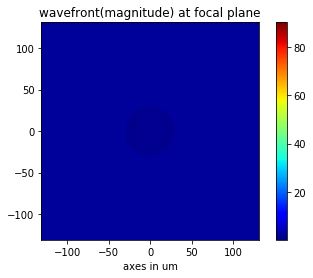

In [11]:
plt.imshow(np.abs(wave_focus),extent=np.array([-L2/2,L2/2,-L2/2,L2/2])*1e6,cmap='jet')
plt.xlabel('axes in um')
plt.title('wavefront(magnitude) at focal plane')
plt.colorbar()
plt.show()

The focal spot size is ~50 pixels and one can't see it when the whole wavefront (40k by 40k) is visualized ! 
Another thing one can notice is the faint outline of a square, this is because the output grid dimensions are different from the input grid dimensions and the length of the side of this square is nothing but the support length of the input plane.

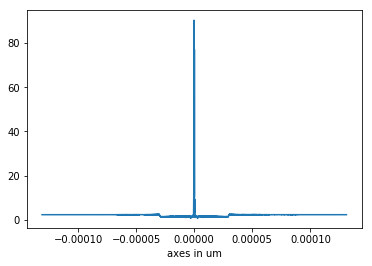

slice in x-direction along the focal plane


In [12]:
x = np.linspace(-1,1,grid_size)*L2/2
plt.plot(x,np.abs(wave_focus)[int(grid_size/2),:])
plt.xlabel('axes in um')
plt.show()
print('slice in x-direction along the focal plane')

In [18]:
focal_spot_size = 250
focal_spot,x_,y_,max_val = prop_utils.get_focal_spot(np.abs(wave_focus),grid_size,focal_spot_size)

max_loc : 27647 27614 250 250


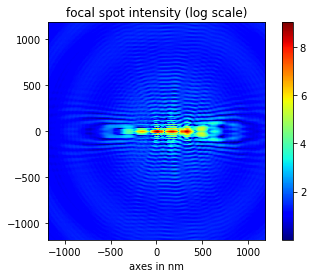

In [19]:
plt.imshow(np.log(np.abs(focal_spot)**2+1),extent = np.array([-1,1,-1,1])*(focal_spot_size)*(L2/grid_size)*(1e9),cmap='jet')
plt.title('focal spot intensity (log scale)')
plt.xlabel('axes in nm')
plt.colorbar()
plt.show()

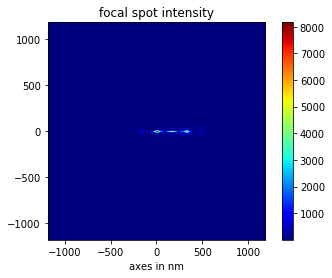

In [20]:
plt.imshow((np.abs(focal_spot)**2),extent = np.array([-1,1,-1,1])*(focal_spot_size)*(L2/grid_size)*(1e9),cmap='jet')
plt.title('focal spot intensity')
plt.xlabel('axes in nm')
plt.colorbar()
plt.show()

In [21]:
#np.save('foc_spot_Q_3.33_'+str(round(angle,3))+'_degree.npy',focal_spot)
#np.save('foc_loc_Q_3.33_'+str(round(angle,3))+'_degree.npy',np.array([x_,y_]))    